# SD212: Graph mining
## Solution to Lab 1: Graph structure

In this lab, you will check three structural properties of real graphs:
* the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions) of degrees,
* the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* the tendency to [cluster](https://en.wikipedia.org/wiki/Clustering_coefficient).

## Import

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
import sknetwork as skn

In [3]:
# check version
if skn.__version__ != '0.31.0':
    print('Please upgrade scikit-network.')

In [4]:
from sknetwork.data import load_netset, erdos_renyi
from sknetwork.path import get_distances, get_shortest_path
from sknetwork.utils import get_neighbors, bipartite2undirected
from sknetwork.topology import get_clustering_coefficient

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr) collection for details):
* Openflights (graph)
* WikiVitals (directed graph)
* Cinema (bipartite graph)

In [5]:
openflights = load_netset('openflights')

Parsing files...
Done.


In [6]:
type(openflights)

sknetwork.data.base.Bunch

In [7]:
dataset = openflights

In [8]:
dataset.meta

{'name': 'openflights',
 'description': 'Airports with daily number of flights between them.',
 'source': 'https://openflights.org'}

In [9]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [10]:
cinema = load_netset('cinema')

Parsing files...
Done.


## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* in-degrees and out-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale.
* Conclude: do you consider that these are power-law graphs?

In [11]:
dataset = wikivitals

In [12]:
adjacency = dataset.adjacency

In [13]:
adjacency

<10011x10011 sparse matrix of type '<class 'numpy.bool_'>'
	with 824999 stored elements in Compressed Sparse Row format>

In [14]:
n = adjacency.shape[0]

In [15]:
out_degrees = adjacency.dot(np.ones(n))

In [16]:
in_degrees = adjacency.T.dot(np.ones(n))

In [17]:
def plot_loglog(degrees):
    """Plot the degree distribution in log-log scale and compare with that of a random graph.
    
    Parameters
    ----------
    degrees : array
        vector of degrees of the graph.
    """
    n = len(degrees)
    # comparison with a random graph
    adjacency_random = erdos_renyi(n, np.sum(degrees) / n / (n-1))
    degrees_random = adjacency_random.dot(np.ones(n))
    plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw = 3, label='Real graph')
    plt.loglog(np.sort(degrees_random), 1 - np.arange(n) / n, lw = 3, label = 'Random graph')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

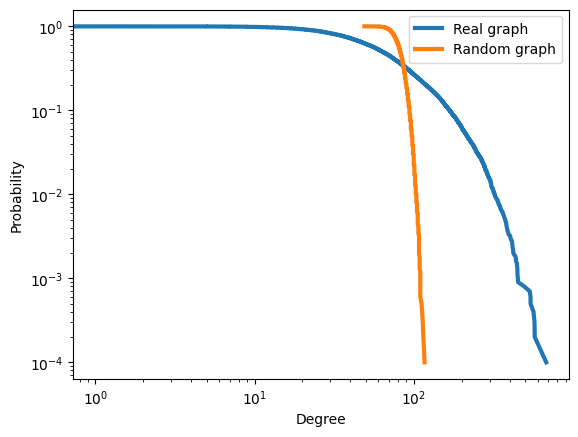

In [18]:
plot_loglog(out_degrees)

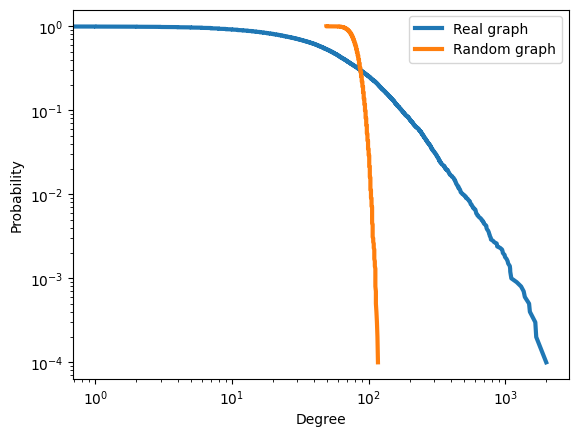

In [19]:
plot_loglog(in_degrees)

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Give a shortest path of maximum length starting from **Paris Charles de Gaulle** airport in Openflights.<br> 
List the corresponding airports.
* Give a shortest path from [Plato](https://en.wikipedia.org/wiki/Plato) to [Platini](https://en.wikipedia.org/wiki/Michel_Platini) in WikiVitals.<br>
List the corresponding articles.

In [20]:
dataset = openflights

In [21]:
adjacency = dataset.adjacency > 0

In [22]:
names = dataset.names

In [23]:
{i: name for i, name in enumerate(names) if 'de Gaulle' in name}

{622: 'Charles de Gaulle International Airport'}

In [24]:
source = 622

In [25]:
distances = get_distances(adjacency, source)

In [26]:
max(distances)

7

In [27]:
destination = np.argmax(distances)

In [28]:
shortest_path_tree = get_shortest_path(adjacency, source)

In [29]:
destination = np.argmax(distances)

In [30]:
names[destination]

'Peawanuck Airport'

In [31]:
node = destination
path = [destination]
while node != source:
    node = get_neighbors(shortest_path_tree, node, transpose=True)[0]
    path = [node] + path

In [32]:
len(path)

8

In [33]:
print(names[path])

['Charles de Gaulle International Airport'
 'Lester B. Pearson International Airport' 'Timmins/Victor M. Power'
 'Moosonee Airport' 'Fort Albany Airport' 'Kashechewan Airport'
 'Attawapiskat Airport' 'Peawanuck Airport']


In [34]:
dataset = wikivitals

In [35]:
adjacency = dataset.adjacency
names = dataset.names

In [36]:
source = np.flatnonzero(names == 'Plato')[0]
destination = np.flatnonzero(names == 'Michel Platini')[0]

In [37]:
shortest_path_tree = get_shortest_path(adjacency, source)

In [38]:
node = destination
path = [destination]
while node != source:
    node = get_neighbors(shortest_path_tree, node, transpose=True)[0]
    path = [node] + path

In [39]:
print(names[path])

['Plato' 'Naples' 'Diego Maradona' 'Michel Platini']


## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [40]:
dataset = openflights
adjacency = dataset.adjacency
names = dataset.names

In [41]:
source = 622
names[source]

'Charles de Gaulle International Airport'

In [42]:
distances = get_distances(adjacency, source)

In [43]:
np.mean(distances <= 1)

0.07555699063609946

In [44]:
np.mean(distances <= 2)

0.6189861155957378

In [45]:
np.mean(distances <= 3)

0.9089441394898289

In [46]:
dataset = wikivitals
adjacency = dataset.adjacency
names = dataset.names

In [47]:
source = np.flatnonzero(names=='Paris')[0]

In [48]:
names[source]

'Paris'

In [49]:
distances = get_distances(adjacency, source)

In [50]:
np.mean(distances <= 1)

0.0425531914893617

In [51]:
np.mean(distances <= 2)

0.6771551293577065

In [52]:
np.mean(distances <= 3)

0.9963040655279193

## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors (**without** building the co-starring actor graph).
* Plot the corresponding histogram.

In [53]:
dataset = cinema

In [54]:
dataset.meta

{'name': 'cinema',
 'source': 'https://yago-knowledge.org',
 'description': 'Graph between movies and actors.'}

In [55]:
biadjacency = dataset.biadjacency

In [56]:
biadjacency

<88440x44586 sparse matrix of type '<class 'numpy.bool_'>'
	with 304006 stored elements in Compressed Sparse Row format>

In [57]:
movies = dataset.names_row
actors = dataset.names_col

In [58]:
len(movies)

88440

In [59]:
len(actors)

44586

In [60]:
source = np.flatnonzero(actors == 'Kevin Bacon')[0]

In [61]:
# actors are on columns
_, distances = get_distances(biadjacency, source_col=source)

In [62]:
# distances to actors are even in the bipartite graph
any(distances % 2)

False

In [63]:
# actors with Bacon number 1 (have co-starred in a movie with Kevin Bacon)
actors[np.flatnonzero(distances == 2)]

array(['Anthony LaPaglia', 'Sissy Spacek', 'Meryl Streep', 'Fred Ward',
       'Aisha Tyler', 'Michael Gross', 'Stephen Blackehart',
       'Jennifer Morrison', 'John Goodman', 'John Hurt',
       'Evan Rachel Wood', 'Wilford Brimley', 'Brad Renfro', 'Lucy Fry',
       'Brad Pitt', 'Benedict Cumberbatch', 'Mickey Rourke',
       'Sam Rockwell', 'Pruitt Taylor Vince', 'Mos Def',
       'Theresa Russell', 'Robert De Niro', 'Kiefer Sutherland',
       'Oliver Stone', 'Tommy Lee Jones', 'William Baldwin',
       'Courtney Love', 'Jay Mohr', 'John Lithgow', 'Oliver Platt',
       'Laurence Fishburne', 'Sean Penn', 'Elizabeth Perkins',
       'Charlize Theron', 'Christian Slater', 'Kevin Costner',
       'Kevin Pollak', 'Aidan Quinn', 'Embeth Davidtz', 'J. K. Simmons',
       'Olympia Dukakis', 'David Alan Grier', 'Sean Astin',
       'William Devane', 'Neve Campbell', 'Andy García', 'Frank Langella',
       'Jeff Bridges', 'Michael Shannon', 'John C. Reilly',
       "Frances O'Connor", 'Ed 

In [64]:
bacon_numbers = distances // 2

In [65]:
bacon_numbers[actors == 'Kevin Bacon']

array([0], dtype=int32)

In [66]:
bacon_numbers[actors == 'Julia Roberts']

array([1], dtype=int32)

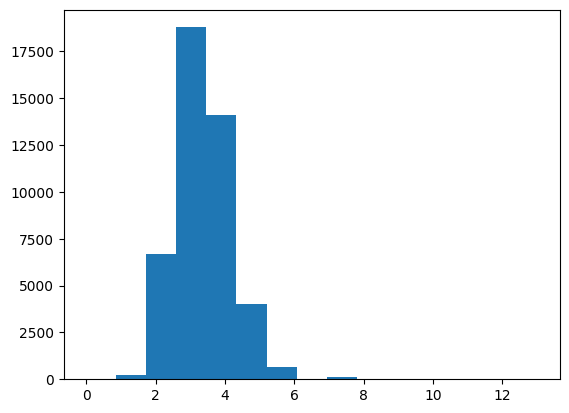

In [67]:
plt.hist(bacon_numbers, bins=15);

Finally, we check the clustering property of real graph (my friends tend to be friends).

## To do


* Compute the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph).
* Compare with that of a random graph of same size.

In [68]:
dataset = openflights

In [69]:
adjacency = dataset.adjacency

In [70]:
get_clustering_coefficient(adjacency)

0.25107219520077

In [71]:
n = adjacency.shape[0]
adjacency_random = erdos_renyi(n, np.sum(adjacency.data) / n / (n-1))

In [72]:
get_clustering_coefficient(adjacency_random)

0.006847689850890971